In [179]:
import pandas as pd
import numpy as np
from datetime import date
import numpy_financial as npf
import yfinance
import plotly.express as px

In [112]:
Interest_Rate = 0.0275
stock_interest = 0.08

Years = 29
Payments_Year = 12

Property_tax = 13047
Utilities = 2000

# Total Cash
total = 680000
# Principal on house
Principal = 482368.34
Addl_Princ = 0
start_date = (date(2022,1,1))

### This is a monthly mortgage payment given the conditions set above

In [113]:
pmt = npf.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)

In [114]:
pmt = round(pmt, 2)
pmt

-2013.03

In [115]:
rng = pd.date_range(start_date, periods=Years * Payments_Year, freq='MS')
rng.name = "Payment_Date"

In [120]:
df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest'], dtype='float')
df.reset_index(inplace=True)
df.index += 1
df.index.name = "Period"

In [121]:
df["Payment"] = npf.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)
df["Principal"] = npf.ppmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)
df["Interest"] = npf.ipmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)

In [122]:
df = df.round(2)

In [123]:
df

,Payment_Date,Payment,Principal,Interest
Period,,,,
1,2022-01-01,-2013.03,-907.61,-1105.43
2,2022-02-01,-2013.03,-909.69,-1103.35
3,2022-03-01,-2013.03,-911.77,-1101.26
4,2022-04-01,-2013.03,-913.86,-1099.17
5,2022-05-01,-2013.03,-915.95,-1097.08
...,...,...,...,...
344,2050-08-01,-2013.03,-1990.13,-22.91
345,2050-09-01,-2013.03,-1994.69,-18.35
346,2050-10-01,-2013.03,-1999.26,-13.78


In [ ]:
TOTALS_INVEST = []
TOTALS_LUMP = []
one_year_cash = -(pmt * (Payments_Year)) + Property_tax + Utilities
cash = one_year_cash
invested = total - cash
for ind, row in df.iterrows():
    print(df["Payment_Date"][ind].date())
    print("Total:", cash + invested)
    print("Investment:", invested)
    print("Cash:", "\x1b[95m{}\x1b[0m".format(cash))
    stock_earnings = invested * (stock_interest/Payments_Year)
    print("Earn:", "\x1b[32m{}\x1b[0m".format(stock_earnings))
    invested += stock_earnings
    if df["Payment_Date"][ind].date().month == 1:
        if df["Payment_Date"][ind].date().year != df["Payment_Date"][1].date().year:
            # Not Year One
            one_year_cash = -(pmt * (Payments_Year)) + (Property_tax * (1.02**(round(ind/12, 2)))) + Utilities
            print("\x1b[34m{}\x1b[0m".format("Refilling Cash {}".format(one_year_cash)))
            invested -= one_year_cash
            cash += one_year_cash
            print("Cash:", "\x1b[95m{}\x1b[0m".format(cash))
            cash -= Property_tax * (1.02**(round(ind/12, 2)))
            print("Property Tax:", "\x1b[31m{}\x1b[0m".format(-(Property_tax * (1.02**(round(ind/12, 2))))))
            cash -= Utilities
            print("Utilities:", "\x1b[31m{}\x1b[0m".format(-Utilities))
            print("Cash:", "\x1b[95m{}\x1b[0m".format(cash))
        else:
            # Year One
            one_year_cash = -(pmt * (Payments_Year)) + Property_tax + Utilities
            cash -= Property_tax
            print("Property Tax:", "\x1b[31m{}\x1b[0m".format(-(Property_tax )))
            cash -= Utilities
            print("Utilities:", "\x1b[31m{}\x1b[0m".format(-Utilities))
            print("Cash:", "\x1b[95m{}\x1b[0m".format(cash))
    print("Pay:", "\x1b[31m{}\x1b[0m".format(pmt))
    cash += pmt
    cash = round(cash, 3)
    print("New Investment: ", invested)
    print("New Cash:", cash)
    TOTALS_INVEST.append(invested + cash)
    print("New total:", invested + cash)
    print()
    

In [156]:
def strategy_two(df:pd.DataFrame, VERBOSE:bool=True):
    '''Invest all money, but withdraw one year worth of cash for mortgage, property tax, and utilities'''
    TOTALS_INVEST = []
    one_year_cash = -(pmt * (Payments_Year)) + Property_tax + Utilities # Define one year of liquidity in year one
    cash = one_year_cash
    invested = total - cash
    for ind, row in df.iterrows():
        stock_earnings = invested * (stock_interest/Payments_Year)
        if VERBOSE:
            print(df["Payment_Date"][ind].date())
            print("Total:", cash + invested)
            print("Investment:", invested)
            print("Cash:", "\x1b[95m{}\x1b[0m".format(cash))
            print("Earn:", "\x1b[32m{}\x1b[0m".format(stock_earnings))
        invested += stock_earnings
        # Paying Property Tax and Utilities
        if df["Payment_Date"][ind].date().month == 1:
            if df["Payment_Date"][ind].date().year != df["Payment_Date"][1].date().year:
                # Not Year One
                new_property_tax = Property_tax * (1.02**(round(ind/12, 2))) # new property tax
                one_year_cash = -(pmt * (Payments_Year)) + new_property_tax + Utilities # Define one year of liquidity
                # Move money from investments into cash
                invested -= one_year_cash
                cash += one_year_cash
                if VERBOSE:
                    print("\x1b[34m{}\x1b[0m".format("Refilling Cash {}".format(one_year_cash)))
                    print("Cash:", "\x1b[95m{}\x1b[0m".format(cash))
                # Pay property tax and utilities
                cash -= new_property_tax
                cash -= Utilities
                if VERBOSE:
                    print("Property Tax:", "\x1b[31m{}\x1b[0m".format(-new_property_tax))
                    print("Utilities:", "\x1b[31m{}\x1b[0m".format(-Utilities))
                    print("Cash:", "\x1b[95m{}\x1b[0m".format(cash))
            else:
                # Year One, property tax does not compound
                cash -= Property_tax
                cash -= Utilities
                if VERBOSE:
                    print("Property Tax:", "\x1b[31m{}\x1b[0m".format(-(Property_tax )))
                    print("Utilities:", "\x1b[31m{}\x1b[0m".format(-Utilities))
                    print("Cash:", "\x1b[95m{}\x1b[0m".format(cash))
        cash += pmt
        cash = round(cash, 3)
        TOTALS_INVEST.append(invested + cash)
        if VERBOSE:
            print("Pay:", "\x1b[31m{}\x1b[0m".format(pmt))
            print("New Investment: ", invested)
            print("New Cash:", cash)
            print("New total:", invested + cash)
            print()
    return TOTALS_INVEST

In [157]:
def strategy_one(df:pd.DataFrame, VERBOSE:bool=True):
    '''Pay principal then invest excess, payout property tax from investments'''
    TOTALS_INVEST = []
    invested = total - Principal
    stock_earnings = invested * (stock_interest/Payments_Year)
    for ind, row in df.iterrows():
        if VERBOSE:
            print(df["Payment_Date"][ind].date())
            print("Investment:", invested)
            print("Earn:", "\x1b[32m{}\x1b[0m".format(stock_earnings))
            print("Pay Utilities:", "\x1b[31m{}\x1b[0m".format(-Utilities/12))
        stock_earnings = invested * (stock_interest/Payments_Year)
        invested += stock_earnings
        # Paying Utilities
        invested -= Utilities/12
        # Paying Property Tax
        if df["Payment_Date"][ind].date().month == 1:
            if df["Payment_Date"][ind].date().year != df["Payment_Date"][1].date().year:
                # Not Year One
                new_property_tax = Property_tax * (1.02**(round(ind/12, 2))) # new property tax
                invested -= new_property_tax # Payment
                if VERBOSE:
                    print("Property Tax:", "\x1b[31m{}\x1b[0m".format(-new_property_tax))
            else:
                # Year One, property tax does not compound
                invested -= Property_tax
                if VERBOSE:
                    print("Property Tax:", "\x1b[31m{}\x1b[0m".format(-(Property_tax )))
        TOTALS_INVEST.append(invested)
        if VERBOSE:
            print("New Investment: ", invested)
            print()
    return TOTALS_INVEST
    

In [164]:
def strategy_three(df:pd.DataFrame, VERBOSE:bool=True):
    '''Invest all money, but withdraw one year worth of cash for mortgage, property tax, and utilities'''
    TOTALS_INVEST = []
    one_year_cash = -(pmt * (Payments_Year)) + Property_tax + Utilities # Define one year of liquidity in year one
    invested = total - one_year_cash
    for ind, row in df.iterrows(): 
        stock_earnings = invested * (stock_interest/Payments_Year)
        if VERBOSE:
            print(df["Payment_Date"][ind].date())
            print("Total:", one_year_cash + invested)
            print("Investment:", invested)
            print("Cash:", "\x1b[95m{}\x1b[0m".format(one_year_cash))
            print("Earn:", "\x1b[32m{}\x1b[0m".format(stock_earnings))
        invested += stock_earnings
        # If not year one, pay from investments
        if df["Payment_Date"][ind].date().year != df["Payment_Date"][1].date().year:
            # Paying Property Tax and Utilities
            # Paying Utilities
            invested -= Utilities/12
            invested += pmt
        # If year one, pay with cash
        else:
            one_year_cash += pmt
            one_year_cash -= Utilities/12
        # if January
        if df["Payment_Date"][ind].date().month == 1:
            # January, not in year one, pay from investments
            if df["Payment_Date"][ind].date().year != df["Payment_Date"][1].date().year:
                new_property_tax = Property_tax * (1.02**(round(ind/12, 2))) # new property tax
                # Pay property tax
                invested -= new_property_tax
                if VERBOSE:
                    print("Property Tax:", "\x1b[31m{}\x1b[0m".format(-new_property_tax))
                    print("Cash:", "\x1b[95m{}\x1b[0m".format(one_year_cash))
            # January in year one, pay from cash
            else:
                # Year One
                one_year_cash -= Property_tax
                if VERBOSE:
                    print("Property Tax:", "\x1b[31m{}\x1b[0m".format(-(Property_tax )))
                    print("Utilities:", "\x1b[31m{}\x1b[0m".format(-Utilities))
                    print("Cash:", "\x1b[95m{}\x1b[0m".format(one_year_cash))
        TOTALS_INVEST.append(invested + one_year_cash)
        if VERBOSE:
            print("Pay:", "\x1b[31m{}\x1b[0m".format(pmt))
            print("New Investment: ", invested)
            print("New Cash:", one_year_cash)
            print("New total:", invested + one_year_cash)
            print()
    return TOTALS_INVEST

In [165]:
strategy_three(df, True)

2022-01-01
Total: 680000.0
Investment: 640796.64
Cash: 39203.36
Earn: 4271.9776
Property Tax: -13047
Utilities: -2000
Cash: 23976.663333333338
Pay: -2013.03
New Investment:  645068.6176
New Cash: 23976.663333333338
New total: 669045.2809333333

2022-02-01
Total: 669045.2809333333
Investment: 645068.6176
Cash: 23976.663333333338
Earn: 4300.457450666667
Pay: -2013.03
New Investment:  649369.0750506667
New Cash: 21796.96666666667
New total: 671166.0417173334

2022-03-01
Total: 671166.0417173334
Investment: 649369.0750506667
Cash: 21796.96666666667
Earn: 4329.127167004445
Pay: -2013.03
New Investment:  653698.2022176711
New Cash: 19617.270000000004
New total: 673315.4722176711

2022-04-01
Total: 673315.4722176711
Investment: 653698.2022176711
Cash: 19617.270000000004
Earn: 4357.988014784474
Pay: -2013.03
New Investment:  658056.1902324556
New Cash: 17437.573333333337
New total: 675493.763565789

2022-05-01
Total: 675493.763565789
Investment: 658056.1902324556
Cash: 17437.573333333337
Earn:

Total: 887187.7669910013
Investment: 887187.7669910013
Cash: 4.177991286269389e-12
Earn: 5914.585113273342
Pay: -2013.03
New Investment:  890922.655437608
New Cash: 4.177991286269389e-12
New total: 890922.655437608

2032-07-01
Total: 890922.655437608
Investment: 890922.655437608
Cash: 4.177991286269389e-12
Earn: 5939.484369584054
Pay: -2013.03
New Investment:  894682.4431405254
New Cash: 4.177991286269389e-12
New total: 894682.4431405254

2032-08-01
Total: 894682.4431405254
Investment: 894682.4431405254
Cash: 4.177991286269389e-12
Earn: 5964.549620936837
Pay: -2013.03
New Investment:  898467.2960947956
New Cash: 4.177991286269389e-12
New total: 898467.2960947956

2032-09-01
Total: 898467.2960947956
Investment: 898467.2960947956
Cash: 4.177991286269389e-12
Earn: 5989.781973965304
Pay: -2013.03
New Investment:  902277.3814020943
New Cash: 4.177991286269389e-12
New total: 902277.3814020943

2032-10-01
Total: 902277.3814020943
Investment: 902277.3814020943
Cash: 4.177991286269389e-12
Earn:

Total: 1298965.9018001838
Investment: 1298965.9018001838
Cash: 4.177991286269389e-12
Earn: 8659.772678667892
Pay: -2013.03
New Investment:  1305445.977812185
New Cash: 4.177991286269389e-12
New total: 1305445.977812185

2042-06-01
Total: 1305445.977812185
Investment: 1305445.977812185
Cash: 4.177991286269389e-12
Earn: 8702.973185414567
Pay: -2013.03
New Investment:  1311969.2543309329
New Cash: 4.177991286269389e-12
New total: 1311969.2543309329

2042-07-01
Total: 1311969.2543309329
Investment: 1311969.2543309329
Cash: 4.177991286269389e-12
Earn: 8746.461695539552
Pay: -2013.03
New Investment:  1318536.0193598056
New Cash: 4.177991286269389e-12
New total: 1318536.0193598056

2042-08-01
Total: 1318536.0193598056
Investment: 1318536.0193598056
Cash: 4.177991286269389e-12
Earn: 8790.24012906537
Pay: -2013.03
New Investment:  1325146.5628222043
New Cash: 4.177991286269389e-12
New total: 1325146.5628222043

2042-09-01
Total: 1325146.5628222043
Investment: 1325146.5628222043
Cash: 4.17799128

[669045.2809333333,
 671166.0417173334,
 673315.4722176711,
 675493.763565789,
 677701.1081673387,
 679937.6997106764,
 682203.7331754141,
 684499.404841028,
 686824.9122955238,
 689180.4544441607,
 691566.2315182328,
 693982.44508391,
 683100.2587686278,
 685474.5638270853,
 687864.6975859326,
 690270.7655698388,
 692692.8740069711,
 695131.1298336843,
 697585.6406992422,
 700056.5149705706,
 702543.861737041,
 705047.790815288,
 707568.4127540565,
 710105.8388390836,
 699064.5610298523,
 701545.2947700513,
 704042.566735185,
 706556.4871800862,
 709087.1670946202,
 711634.7182085844,
 714199.2529966416,
 716780.8846832858,
 719379.7272478411,
 721995.8954294934,
 724629.5047323566,
 727280.6714305724,
 716081.9801039213,
 718676.1633046141,
 721287.6410599783,
 723916.5286670448,
 726562.9421914918,
 729226.9984727685,
 731908.8151292535,
 734608.5105634485,
 737326.2039672049,
 740062.0153269863,
 742816.0654291662,
 745588.4758653607,
 734234.4859188843,
 736949.6858250102,
 739682

In [176]:
df["S3"] = strategy_three(df, False)
df["S2"] = strategy_two(df, False)
df["S1"] = strategy_one(df, False)
df["Break_Even"] = 0

In [177]:
df.round(3)

,Payment_Date,Payment,Principal,Interest,Strategy_1,Strategy_2,Break_Even,Strategy_3,"All invested, pay monthly mortgage","Keep 1 year liquid, rest invested, pay monthly mortgage","Pay off house, then invest",S3,S2,S1
Period,,,,,,,,,,,,,,
1,2022-01-01,-2013.03,-907.61,-1105.43,185735.538,667211.948,0,669045.281,669045.281,667211.948,185735.538,669045.281,667211.948,185735.538
2,2022-02-01,-2013.03,-909.69,-1103.35,186807.108,669499.375,0,671166.042,671166.042,669499.375,186807.108,671166.042,669499.375,186807.108
3,2022-03-01,-2013.03,-911.77,-1101.26,187885.822,671815.472,0,673315.472,673315.472,671815.472,187885.822,673315.472,671815.472,187885.822
4,2022-04-01,-2013.03,-913.86,-1099.17,188971.728,674160.430,0,675493.764,675493.764,674160.430,188971.728,675493.764,674160.430,188971.728
5,2022-05-01,-2013.03,-915.95,-1097.08,190064.872,676534.442,0,677701.108,677701.108,676534.442,190064.872,677701.108,676534.442,190064.872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2050-08-01,-2013.03,-1990.13,-22.91,-85678.085,1880151.477,0,1978591.527,1978591.527,1880151.477,-85678.085,1978591.527,1880151.477,-85678.085
345,2050-09-01,-2013.03,-1994.69,-18.35,-86415.939,1890619.109,0,1989602.440,1989602.440,1890619.109,-86415.939,1989602.440,1890619.109,-86415.939
346,2050-10-01,-2013.03,-1999.26,-13.78,-87158.712,1901169.946,0,2000686.760,2000686.760,1901169.946,-87158.712,2000686.760,1901169.946,-87158.712


<AxesSubplot:xlabel='Payment_Date'>

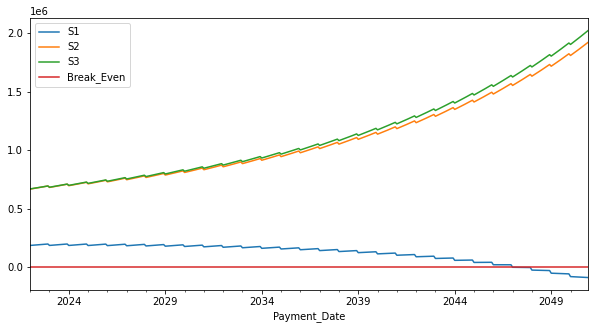

In [178]:
df.plot(x='Payment_Date', y=["S1",
                             "S2",
                             "S3",
                             "Break_Even"], figsize=(10, 5))

In [181]:
fig = px.line(df, x="Payment_Date", y=["S1",
                             "S2",
                             "S3",
                             "Break_Even"], title='Payment Strategy Comparison')
fig.show()